In [1]:
from glob import glob
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/jellyfish/original/'

idg = ImageDataGenerator(rescale=1./255)

generator = idg.flow_from_directory(
    root,
    target_size=(244, 244),
    batch_size=8,
    class_mode='categorical'
)

print(generator.class_indices)


Found 900 images belonging to 6 classes.
{'Moon_jellyfish': 0, 'barrel_jellyfish': 1, 'blue_jellyfish': 2, 'compass_jellyfish': 3, 'lions_mane_jellyfish': 4, 'mauve_stinger_jellyfish': 5}


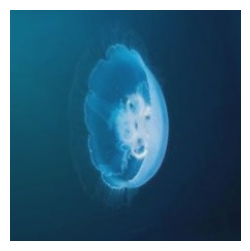

In [2]:
import cv2
import matplotlib.pyplot as plt

image = cv2.cvtColor(cv2.imread(generator.filepaths[100]), cv2.COLOR_BGR2RGB)

def show_image(image):
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.axis('off')

show_image(image)

In [3]:
import pandas as pd

x_df = pd.DataFrame({'file_paths': generator.filepaths, 'targets': generator.classes})
x_df.loc[:, 'file_paths'] = x_df.file_paths.apply(lambda x: x.replace('\\', '/'))
x_df

,file_paths,targets
0,./datasets/jellyfish/original/Moon_jellyfish/0...,0
1,./datasets/jellyfish/original/Moon_jellyfish/0...,0
2,./datasets/jellyfish/original/Moon_jellyfish/0...,0
3,./datasets/jellyfish/original/Moon_jellyfish/0...,0
4,./datasets/jellyfish/original/Moon_jellyfish/0...,0
...,...,...
895,./datasets/jellyfish/original/mauve_stinger_je...,5
896,./datasets/jellyfish/original/mauve_stinger_je...,5
897,./datasets/jellyfish/original/mauve_stinger_je...,5
898,./datasets/jellyfish/original/mauve_stinger_je...,5


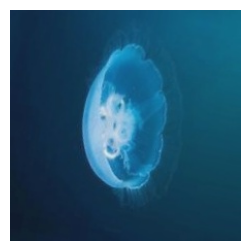

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Horizontal Filp: 좌우반전 적용
# 적용하더라도 반드시 변환되지 않는다. 특정 확률로 랜덤하게 적용하기 때문이다.
idg = ImageDataGenerator(horizontal_flip=True)

# ImageDataGenerator는 배치 사이즈를 포함한 4차원으로 fro연산되기 때문에
# 기존 image를 한 차원 증가시켜준다.
image_batch = np.expand_dims(image, axis=0)

# 4차원 이미지(배치 사이즈 포함)를 fit에 전달한다.
idg.fit(image_batch)

# fit한 뒤 flow에 다시 넣어준다.
data_generator = idg.flow(image_batch)

# 적용된 이미지를 next로 가져온다.
aug_image_batch = next(data_generator)

# 이미지를 시각화하기 위해서 한 차원 감소시킨 3차원으로 변경해준다.
aug_image = np.squeeze(aug_image_batch)

# 실수에서 정수로 변경 후 출력해준다.
show_image(aug_image.astype('int'))

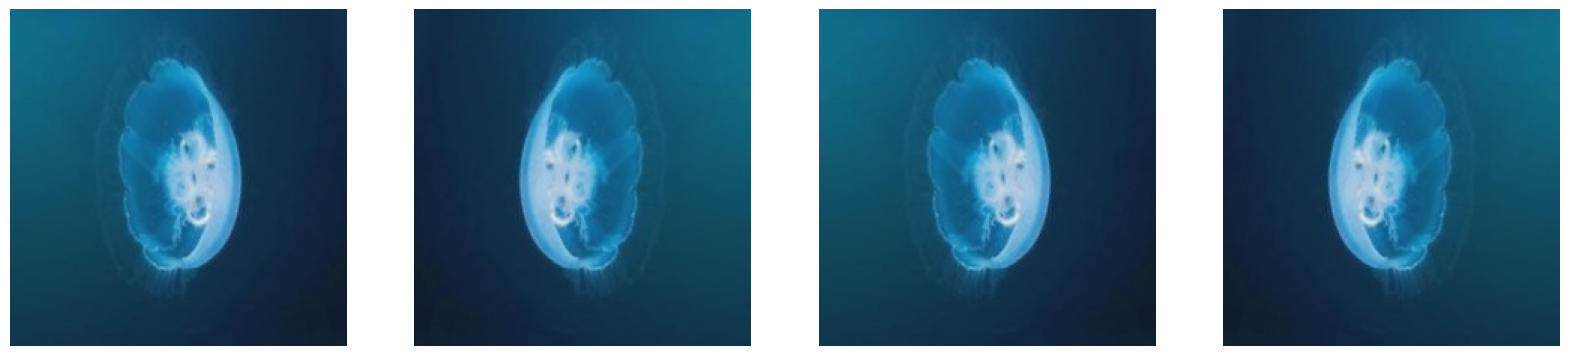

In [6]:
N_IMAGES = 4
fig, axs = plt.subplots(1, N_IMAGES, figsize=(20, 8))

for i in range(N_IMAGES):
    aug_image_batch = next(data_generator)
    aug_image = np.squeeze(aug_image_batch)
    aug_image = aug_image.astype('int')
    axs[i].imshow(aug_image)
    axs[i].axis('off')

In [7]:
# 설명

def show_aug_image_batch(image, idg, n_images=4, to_int=True):
    image_batch = np.expand_dims(image, axis=0)
    idg.fit(image_batch)
    data_generator = idg.flow(image_batch)

    fig, axs = plt.subplots(1, n_images, figsize=(n_images * 5, 8))

    for i in range(N_IMAGES) :
        aug_image_batch = next(data_generator)
        aug_image = np.squeeze(aug_image_batch)
        if to_int :
            aug_image = aug_image.astype('int')

        axs[i].imshow(aug_image)
        axs[i].axis('off')
    

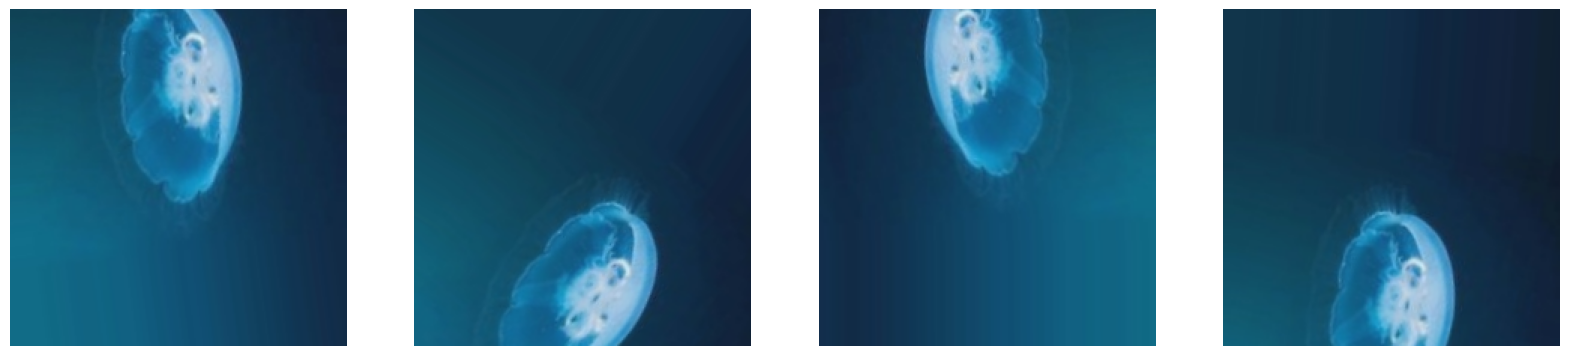

In [8]:
idg = ImageDataGenerator(width_shift_range=0.4,  horizontal_flip=True, vertical_flip=True, rotation_range=45)
show_aug_image_batch(image, idg)

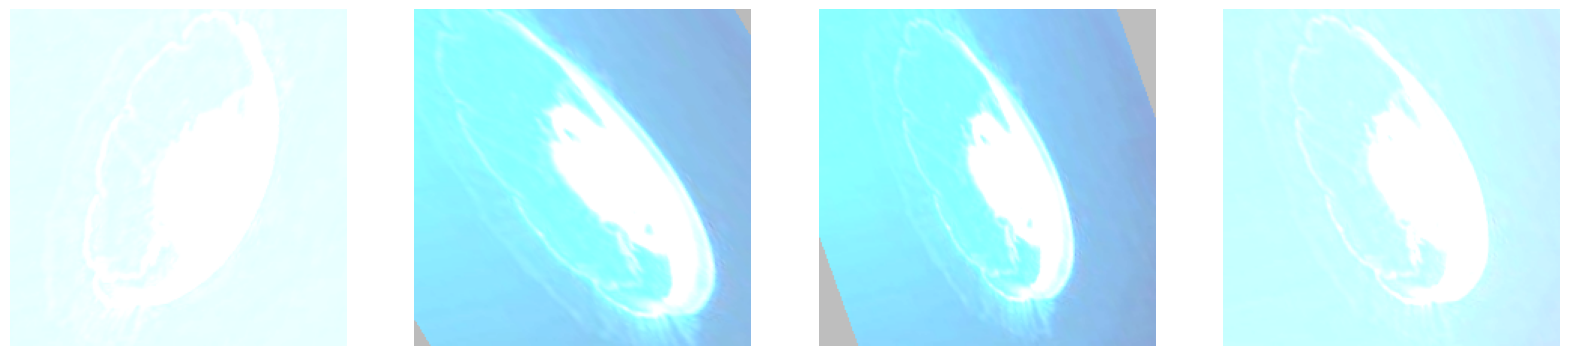

In [9]:
idg = ImageDataGenerator(
    zoom_range=[0.5, 0.9],  # 올바른 zoom_range 설정
    fill_mode='constant',
    cval=45,
    shear_range=45,
    channel_shift_range=190,
    brightness_range=(1.5, 1.9)  
)
show_aug_image_batch(image, idg)

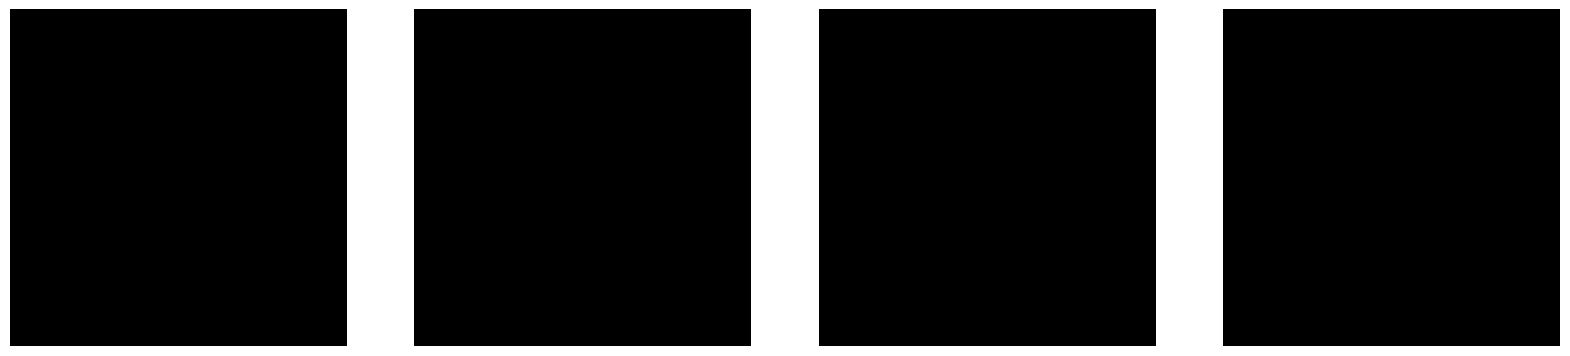

In [10]:
idg = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255
)
show_aug_image_batch(image, idg)

#### ImageDatagenerator를 사용하여 훈련 데이터 준비 완성

In [11]:
def show_images(images, targets, ncols=4, title=None):
    figure, axs = plt.subplots(figsize=(ncols * 5, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i])
        axs[i].set_title(targets[i])

def repeat_aug(original_image=None, target=None, aug=None, ncols=2):
    image_list = [original_image]
    target_list = ['Original']

    for i in range(ncols):
        aug_image = aug(image=original_image)['image']
        image_list.append(aug_image)
        target_list.append(target)

    show_images(image_list, target_list, ncols=ncols)

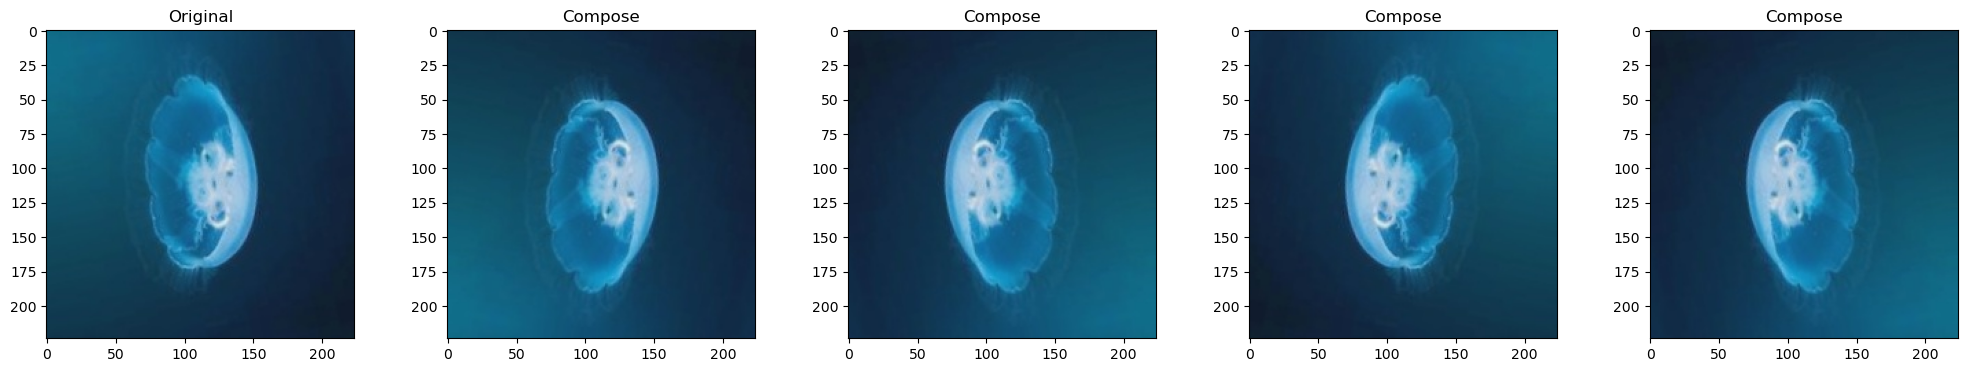

In [12]:
import albumentations as A
aug = A.Compose([
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5)
])

repeat_aug(original_image=image, target='Compose', aug=aug, ncols=5)

In [59]:
import albumentations as A

def transform(image) : 
    aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.OneOf([
            A.ColorJitter(p=1),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)
        ], p=1)
    ], 0.5)

    return aug(image=image)['image']

root = './datasets/jellyfish/Train_Test_Valid/Train'
idg = ImageDataGenerator(preprocessing_function=transform, rescale=1./255)
generator = idg.flow_from_directory(
    root,
    target_size=(244, 244),
    batch_size=8,
    class_mode='categorical'
)

print(generator.class_indices)

Found 900 images belonging to 6 classes.
{'Moon_jellyfish': 0, 'barrel_jellyfish': 1, 'blue_jellyfish': 2, 'compass_jellyfish': 3, 'lions_mane_jellyfish': 4, 'mauve_stinger_jellyfish': 5}


In [60]:
import pandas as pd

x_df = pd.DataFrame({'file_paths': generator.filepaths, 'targets': generator.classes})
x_df.loc[:, 'file_paths'] = x_df.file_paths.apply(lambda x: x.replace('\\', '/'))
x_df

,file_paths,targets
0,./datasets/jellyfish/Train_Test_Valid/Train/Mo...,0
1,./datasets/jellyfish/Train_Test_Valid/Train/Mo...,0
2,./datasets/jellyfish/Train_Test_Valid/Train/Mo...,0
3,./datasets/jellyfish/Train_Test_Valid/Train/Mo...,0
4,./datasets/jellyfish/Train_Test_Valid/Train/Mo...,0
...,...,...
895,./datasets/jellyfish/Train_Test_Valid/Train/ma...,5
896,./datasets/jellyfish/Train_Test_Valid/Train/ma...,5
897,./datasets/jellyfish/Train_Test_Valid/Train/ma...,5
898,./datasets/jellyfish/Train_Test_Valid/Train/ma...,5


In [82]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 244

train_dir = './datasets/jellyfish/Train_Test_Valid/Train/'
validation_dir = './datasets/jellyfish/Train_Test_Valid/valid/'
test_dir = './datasets/jellyfish/Train_Test_Valid/test'

train_data_generator = ImageDataGenerator(rescale=1./255)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

train_generator = train_data_generator.flow_from_directory(
    train_dir,
    target_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= 8,
    class_mode='categorical'
)

validation_generator = validation_data_generator.flow_from_directory(
    validation_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=8,
    class_mode='categorical'
)

test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=8,
    class_mode='categorical'
)



Found 900 images belonging to 6 classes.
Found 39 images belonging to 6 classes.
Found 40 images belonging to 6 classes.


In [65]:
import numpy as np

class_labels = test_generator.classes


classes, counts = np.unique(class_labels, return_counts=True)

# 결과 출력
for class_label, count in zip(classes, counts):
    print(f'Class {class_label}: {count}개')


Class 0: 6개
Class 1: 5개
Class 2: 7개
Class 3: 7개
Class 4: 8개
Class 5: 7개


In [66]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'Moon_jellyfish': 0, 'barrel_jellyfish': 1, 'blue_jellyfish': 2, 'compass_jellyfish': 3, 'lions_mane_jellyfish': 4, 'mauve_stinger_jellyfish': 5}
{'Moon_jellyfish': 0, 'barrel_jellyfish': 1, 'blue_jellyfish': 2, 'compass_jellyfish': 3, 'lions_mane_jellyfish': 4, 'mauve_stinger_jellyfish': 5}
{'Moon_jellyfish': 0, 'barrel_jellyfish': 1, 'blue_jellyfish': 2, 'compass_jellyfish': 3, 'lions_mane_jellyfish': 4, 'mauve_stinger_jellyfish': 5}


In [78]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2

IMAGE_SIZE = 244


input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=256, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(2)(x)

x = Conv2D(filters=256, kernel_size=3, strides=2 ,kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(2)(x)


x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(500, activation='relu')(x)
x = Dropout(rate=0.3)(x)
output = Dense(6, activation='softmax', kernel_initializer='glorot_normal')(x)

model = Model(inputs=input_tensor, outputs=output)
model.summary()


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)          │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 122, 122, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 122, 122, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_44 (Activation)           │ (None, 122, 122, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 61, 61, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 30, 30, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 30, 30, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_45 (Activation)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 15, 15, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_10          │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 500)                 │         128,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 6)                   │           3,006 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 730,802 (2.79 MB)

 Trainable params: 729,778 (2.78 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [79]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

In [80]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

In [83]:
history = model.fit(
    train_generator,
    batch_size=8,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[mcp_cb, rlr_cb, ely_cb]
)

Epoch 1/20


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 220ms/step - acc: 0.2056 - loss: 1.9939 - val_acc: 0.2308 - val_loss: 1.6634 - learning_rate: 0.0010
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 254ms/step - acc: 0.3196 - loss: 1.6000 - val_acc: 0.3333 - val_loss: 1.5752 - learning_rate: 0.0010
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 265ms/step - acc: 0.3752 - loss: 1.5745 - val_acc: 0.4359 - val_loss: 1.5393 - learning_rate: 0.0010
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 32s 284ms/step - acc: 0.3452 - loss: 1.5247 - val_acc: 0.3846 - val_loss: 1.4328 - learning_rate: 0.0010
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 32s 280ms/step - acc: 0.3798 - loss: 1.5005 - val_acc: 0.3590 - val_loss: 1.4792 - learning_rate: 0.0010
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 37s 323ms/step - acc: 0.3832 - loss: 1.4817 - val_acc: 0.4359 - val_loss: 1.4503 - learning_rate: 0.0010
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 44s 384ms/step - acc: 0.4117 - loss: 1.4421 - val_acc: 0.4359 - val_loss: 1.4101 - learning_rate: 1.0

In [91]:
model.evaluate(test_generator, batch_size=8)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - acc: 0.7441 - loss: 0.9852


[1.0887395143508911, 0.675000011920929]

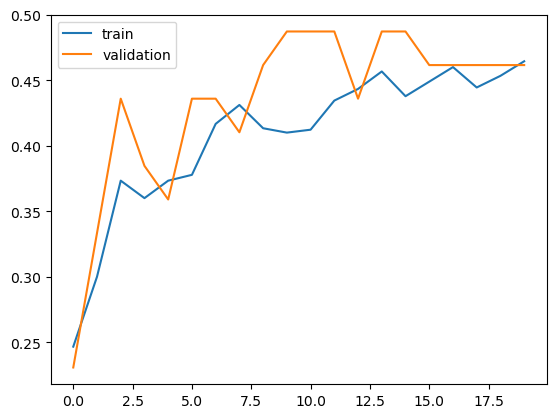

In [92]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()

In [80]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model  # 필요한 경우 모델 로드
import tensorflow as tf


IMAGE_PATH = './datasets/jellyfish/moon.jpg'
IMAGE_SIZE = 244  



class_names = ['barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 
               'lions_mane_jellyfish', 'mauve_stinger_jellyfish', 'Moon_jellyfish']


image = cv2.cvtColor(cv2.imread(IMAGE_PATH), cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
resized_image = np.expand_dims(resized_image, axis=0) 
resized_image = resized_image / 255.0 

predictions = model.predict(resized_image, batch_size=8)
predicted_class = np.argmax(predictions[0])


predicted_class_name = class_names[predicted_class]
print(f"예측 클래스: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
예측 클래스: barrel_jellyfish
